In [1]:
from IPython.core.display import display, HTML

# 노트북 컨테이너 크기 조절
display(HTML("<style>#notebook-container {width: 90% !important; }</style>"))
# 마크다운 폰트
display(HTML("<style>.rendered_html{font-family: 'Noto Sans KR'; font-size: 18pt; line-height: 140%;}</style>"))
# DataFrame 테이블 폰트
display(HTML("<style>.rendered_html table{font-family: 'Noto Sans KR'; font-size: 18pt; line-height: 140%;}</style>"))
# 출력창 폰트
display(HTML("<style>pre{font-family: 'Noto Sans KR', font-size: 18pt;}.rendered_html>ul>li{margin: 10px}</style>"))
display(HTML("<style>div.output_area>pre, div.output_subarea>pre{font-size: 18pt !important; line-height: 140%;}</style>"))
# 코드셀 폰트
display(HTML("<style> .CodeMirror pre {font-family: 'Verdana'; font-size: 20pt !important; line-height: 140%;}</style>"))

## 환경설정

In [36]:
project_name = "의료 보험비 예측" # 프로젝트 이름
class_info = "16차수 A반" # 차수 정보
email = "minhwa.lee@sk.com" # 회사 이메일

## 모듈 설치 및 데이터 다운로드

In [37]:
!pip install --upgrade mySUNI -q

import mySUNI
from mySUNI import cds, utils
print('===' * 15)
print(f'패키지버전: {mySUNI.__version__}')
print('===' * 15)

project = cds.Project(project_name, class_info, email)
project.edu_name = 'mySUNI'

# 이메일 설정 확인
if not project.email:
    raise print("[이메일이 누락되었습니다] 이메일을 설정해 주세요↑↑↑")

print(f'프로젝트명: {project_name}\n차수 정보 : {class_info}\n이  메  일: {email}')
print('===' * 15)

# 다운로드 프로젝트 파일
cds.download_project(project_name, class_info, email)


프로젝트: 의료 보험비 예측
파일 목록

submission.csv
- data/의료 보험비 예측/submission.csv

test.csv
- data/의료 보험비 예측/test.csv

train.csv
- data/의료 보험비 예측/train.csv



## 필요한 모듈 import 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os


# Data 경로 설정
DATA_DIR = 'data'

# 경고 무시
warnings.filterwarnings('ignore')

SEED=123

## 데이터 로드

- `train`: 학습용 데이터셋
- `test`: 결과 예측용 데이터셋

In [39]:
train = pd.read_csv(os.path.join(DATA_DIR, project_name, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, project_name, 'test.csv'))

# 아래 코드는 수정하지 말아 주세요 #
##### 프로젝트 Error 검증 설정 #####
utils.set_plot_error('rmsle')
utils.set_error_values(test.shape[0], evaluation='rmsle')

## 컬럼 (column) 설명 

**컬럼(Features)**
- `age`:  나이
- `sex`: 성별
- `bmi`: 비만지수
- `children`:  건강보험 적용 자녀 수 / 피부양자 수
- `smoker`: 흡연 여부
- `region`: 지역

**타겟(Target)**
- `charges`: 의료 보험비

In [40]:
train.head()

,age,sex,bmi,children,smoker,region,charges
0,50,female,31.600,2,no,southwest,10118.42400
1,39,female,24.225,5,no,northwest,8965.79575
2,47,female,24.100,1,no,southwest,26236.57997
3,45,male,23.560,2,no,northeast,8603.82340
4,26,female,22.230,0,no,northwest,3176.28770


In [41]:
test.head()

,age,sex,bmi,children,smoker,region
0,54,male,21.01,2,no,southeast
1,23,female,28.12,0,no,northwest
2,49,female,42.68,2,no,southeast
3,24,male,25.80,0,no,southwest
4,28,female,27.50,2,no,southwest


## 결측치 체크

In [42]:
# train.isnull().sum()
# test.isnull().sum()

## 문자열 체크

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       788 non-null    int64  
 1   sex       788 non-null    object 
 2   bmi       788 non-null    float64
 3   children  788 non-null    int64  
 4   smoker    788 non-null    object 
 5   region    788 non-null    object 
 6   charges   788 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 43.2+ KB


## 인코딩

In [44]:
train['sex'].value_counts()

male      413
female    375
Name: sex, dtype: int64

In [45]:
# sex 인코딩 변환
train['sex'] = train['sex'].apply(lambda x: 1 if x == 'male' else 0)
test['sex'] = test['sex'].apply(lambda x: 1 if x == 'male' else 0)

In [46]:
# smoker 인코딩 변환

In [47]:
train['smoker'].value_counts()

no     614
yes    174
Name: smoker, dtype: int64

In [48]:
train['smoker'] = train['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
test['smoker'] = test['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

In [49]:
# region 인코딩 변환

In [50]:
# region 별 charges 평균
train.groupby('region')[['charges']].mean()

,charges
region,
northeast,14376.136227
northwest,12617.975481
southeast,14269.051102
southwest,13281.951188


In [51]:
train['region'].value_counts()

southeast    211
southwest    197
northwest    196
northeast    184
Name: region, dtype: int64

In [52]:
# encoding 방식을 변환 => 의료보험비 평균 가격으로 인코딩
region_m = {
    'southeast': 14269, 
    'southwest': 13281, 
    'northwest': 12617, 
    'northeast': 14376
}

In [53]:
train['region'] = train['region'].map(region_m)
test['region'] = test['region'].map(region_m)

## Log Transformation

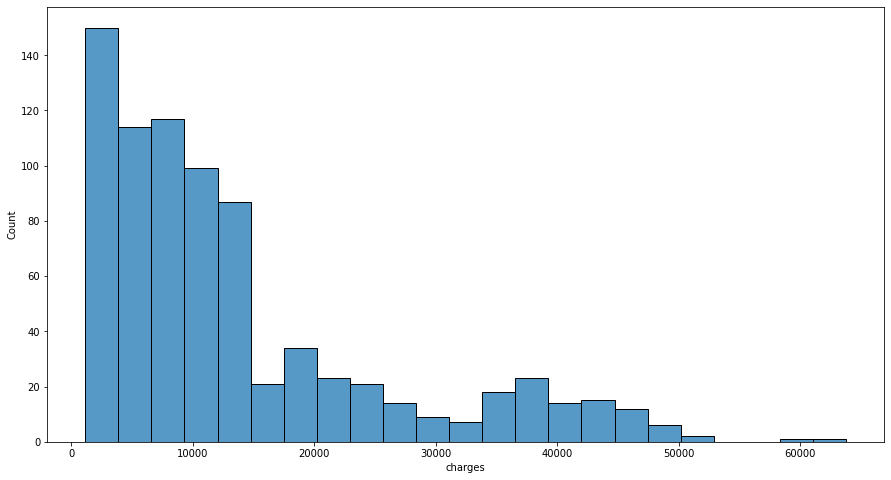

In [54]:
plt.figure(figsize=(15, 8))
sns.histplot(train['charges'])

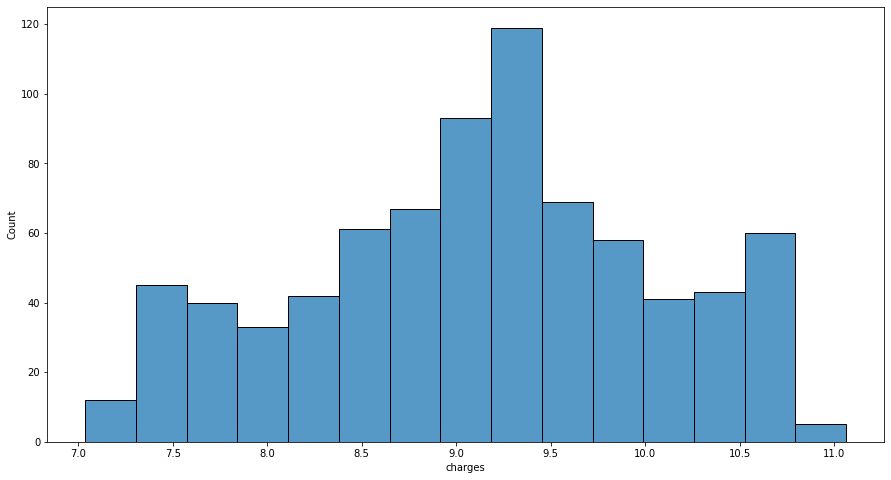

In [55]:
plt.figure(figsize=(15, 8))
sns.histplot(np.log1p(train['charges']))

In [56]:
a = 10

In [57]:
b = np.log1p(a)
b

2.3978952727983707

In [58]:
np.expm1(b)

10.000000000000002

## feature, label

In [59]:
test.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [60]:
features = [
    'age', 
    'sex', 
    'bmi', 
    'children', 
    'smoker', 
    'region'
]

In [61]:
x = train[features]
x.head()

,age,sex,bmi,children,smoker,region
0,50,0,31.600,2,0,13281
1,39,0,24.225,5,0,12617
2,47,0,24.100,1,0,13281
3,45,1,23.560,2,0,14376
4,26,0,22.230,0,0,12617


In [62]:
# log 변환 STEP 1)
y = np.log1p(train['charges'])
y.head()

0     9.222212
1     9.101284
2    10.174948
3     9.060078
4     8.063783
Name: charges, dtype: float64

## train_test_split

In [63]:
from sklearn.model_selection import train_test_split

SEED = 123

x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=SEED)

## model 생성

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [64]:
# 참고 코드
from sklearn.metrics import mean_squared_log_error

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))

In [65]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=SEED, max_depth=5, n_estimators=200)
model.fit(x_train, y_train)
pred = model.predict(x_valid)

RMSLE(np.expm1(y_valid), np.expm1(pred))

0.2897979765405382

## 평가

In [66]:
# log 변환 STEP 2)
RMSLE(np.expm1(y_valid), np.expm1(pred))

0.2897979765405382

## 예측 (test 데이터셋)

In [67]:
# test.csv를 예측한 결과 대입
# log 역변환 STEP 3)
your_answer = model.predict(test[features])
your_answer = np.expm1(your_answer)
your_answer

array([13490.38313076,  3313.59195636, 10208.4136855 ,  2858.64785204,
        5259.12195653, 43358.24884873, 13953.46939061,  3726.99514074,
        5639.21104231, 15001.18157579,  9452.74358762,  1883.60624063,
       14969.36918345,  5805.53207201, 50551.34502268,  5714.68391322,
        2303.25144259,  7883.67471271, 42864.00622023, 35878.68252209,
        4006.22872996,  6121.1226254 ,  7711.14766906, 10433.23139325,
       10170.38652708, 40558.3090214 , 12396.14681838,  9697.73149565,
       24670.21342064, 12460.62323611,  3502.20461699,  6148.75024277,
        5056.80697995, 11325.40355858,  9308.74341811, 13174.03543334,
        6322.98013807,  9628.21866989,  4744.98647343, 10378.31080274,
        3888.81777915, 13975.48362758,  6513.03894896,  5552.20761841,
       14641.41811626, 24347.23180683,  6604.57080956,  5100.00778129,
        2178.95787915, 15541.79221445, 12216.29027636,  1800.93847905,
       13815.54423473, 12854.24336749,  3774.29712118,  6794.08247989,
      

In [68]:
# 값에 오류가 없는지 확인
utils.check_error(your_answer)

[통과] 문제가 발견되지 않았습니다.


## 평가지표 (RMSLE)

In [69]:
# 참고 코드
from sklearn.metrics import mean_squared_log_error

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))

RMSLE(y_valid, pred)

0.02940649180614502

In [70]:
# 시각화 샘플 코드
# utils.plot_error('Your Model', y_valid, pred)

# 시각화 차트 초기화
# utils.clear_error()

## 결과 제출

### 순서대로 평가가 진행됩니다. 실행은 1회만 해주세요.

- 느리다고 중지 후 다시 평가 코드를 실행하는 경우 제출 과정에서 패널티가 발생할 수 있습니다. (제출 횟수 이슈 발생 가능)

- 전체 점수는 [평가시스템](http://manage.jaen.kr)에서 확인할 수 있습니다.
    - 프로젝트 > 의료 보험비 예측 > 리더보드 > 같은 반 리더보드

아래 Cell을 실행하여 예측 결과 업데이트

In [71]:
# 예측 결과 업데이트
submission = pd.read_csv(os.path.join(DATA_DIR, project_name, 'submission.csv'))
submission['charges'] = your_answer
display(submission)
# 제출
project.email = email
project.submit(submission)

,index,charges
0,0,13490.383131
1,1,3313.591956
2,2,10208.413686
3,3,2858.647852
4,4,5259.121957
...,...,...
545,545,12429.244037
546,546,12087.442192
547,547,9641.307507
548,548,5125.368740


파일을 저장하였습니다. 파일명: submission-13-26-00.csv
제출 여부 :success
오늘 제출 횟수 : 7
제출 결과:0.38508828654917804
